
## MVP: Engenharia de Dados

Autor: Leandro Alexandre de Oliveira

Data: 21/12/2025

Matrícula: 4052025001609


## 1- Objetivo
---
O objetivo deste MVP é construir um pipeline de dados na nuvem utilizando **Databricks** para integrar, processar e analisar dados de produção de petróleo da Bacia de Campos. O pipeline abrangerá as etapas de busca, coleta, modelagem, carga, transformação e análise dos dados, visando gerar _insights_ sobre a evolução da produção e apoiar a tomada de decisão.

A Bacia de Campos, localizada entre o norte do Rio de Janeiro e o sul do Espírito Santo, é uma das principais regiões produtoras de petróleo do Brasil, destacando-se pela exploração em águas profundas e ultra profundas. A produção comercial na Bacia de Campos começou em 1977. Com área aproximada de 100.000 km², sua produção tem papel estratégico para o país.

Trata-se de uma bacia madura, na qual a maior parte dos campos encontra-se em fase avançada de maturidade ou já em acentuado declínio produtivo.

Atualmente, a ausência de uma visão consolidada, integrada e acessível dos dados de produção dificulta a identificação dos principais marcos operacionais e fatores que influenciam a produção na bacia. Essa lacuna limita a capacidade analítica e o suporte a decisões estratégicas para otimização das operações. Para isso, serão respondidas as seguintes questões:

1-	Qual o volume total acumulado de produção?

2-	Qual a contribuição da Petrobras nesse total?

3-	Qual é o ranking de produção por empresa, excluindo a Petrobras? 

4-	Quais são os dez principais campos que mais contribuem para a produção total? 

5-	Como a produção da bacia evoluiu ao longo do tempo?

6-	Qual o perfil de produção por faixa de profundidade (águas rasa, profunda e ultra profunda)

7-	Qual o perfil de produção por tipo de petróleo (leve, médio, pesado e extrapesado)?

8-	Quando foi registrado o recorde mensal de produção?

9-  Como é a distribuição da produção acumulada por Unidade da Federação?

10-	Em que momentos foram alcançados os marcos de produção acumulada de 1 bilhão, 5 bilhões, 10 bilhões e 15 bilhões?

É importante destacar que todos os volumes deverão ser expressos em barris de óleo equivalente (boe).
Ao término do projeto, espera-se disponibilizar uma base de dados consolidada, confiável e atualizada, que permita análises robustas sobre a produção de petróleo na Bacia de Campos. Essa base suportará a geração de _insights_ relevantes para identificar tendências, marcos operacionais e fatores críticos, contribuindo diretamente para a melhoria da tomada de decisão estratégica e operacional na indústria petrolífera.




## 2- Preparação do ambiente
--- 




### 2.1. Importação de bibliotecas necessárias e definição de variáveis

In [0]:
# importação de bibliotecas necessárias para manipulação de dados
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import regexp_replace, col, when, to_number

# importação de bibliotecas necessárias para visualização gráfica de dados
import matplotlib.pyplot as plt
import pandas as pd

# definição de variáveis para upload da fonte de dados para o projeto 
catalog = "mvp_producao"
schema = "dados_producao"
volume = "vl_producao"
download_url = "https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP_EngenhariaDados/main/dataset_producao.csv"
file_name = "dataset_producao.csv"
table_name = "producao_mensal"
path_volume = "/Volumes/" + catalog + "/" + schema + "/" + volume
path_table = catalog + "." + schema


### 2.2. Criação do catálogo, esquema e volume 

In [0]:
# Comando SQL para criar o catálogo, verificando se já existe
sql_command = f"CREATE CATALOG IF NOT EXISTS {catalog}"
# Executando o comando SQL para criar o catálogo
spark.sql(sql_command)

# Comando SQL para criar o schema, verificando se já existe
sql_command = f"CREATE SCHEMA IF NOT EXISTS {catalog}.{schema}"
# Executando o comando SQL para criar o schema
spark.sql(sql_command)

# Comando SQL para criar o volume, verificando se já existe
sql_command = f"CREATE VOLUME IF NOT EXISTS {catalog}.{schema}.{volume}"
# Executa o comando SQL para criar o volume
spark.sql(sql_command)


DataFrame[]

## 3- Carga de dados
---

Os dados utilizados neste projeto foram obtidos por meio do [Sistema de Consulta de Dados Públicos](https://cdp.anp.gov.br) (CDP) da ANP (Agência Nacional do Petróleo, Gás Natural e Biocombustíveis), que disponibiliza informações detalhadas sobre a produção e a situação operacional dos agentes da indústria do petróleo, gás natural e biocombustíveis.

A consulta abrangeu todo o histórico de produção da Bacia de Campos até junho de 2025. O resultado foi exportado em formato CSV e armazenado no repositório do **Github** sob o arquivo [dataset_producao.csv](https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP_EngenhariaDados/main/dataset_producao.csv). Posteriormente, esse arquivo foi carregado no ambiente **Delta Lake** do **Databricks** para ser utilizado nas etapas seguintes do projeto, conforme código abaixo.


In [0]:
# carga do arquico csv no Delta Lake do Databricks  
dbutils.fs.cp(f"{download_url}", f"{path_volume}" + "/" + f"{file_name}")

True

### 3.1. Tabela fato

A tabela fato **ft_producao** foi construída a partir do arquivo CSV armazenado no **Delta Lake**, obitido originalmente a partir de consulta ao [Sistema de Consulta de Dados Públicos](https://cdp.anp.gov.br) da ANP. 

Contém volumes mensais de produção de óleo e gás classificados por campo, empresa concessionária, faixa de profundidade e tipo de petróleo.


### 3.2. Tabelas Dimensão

As tabelas dimensão também foram derivadas do arquivo  armazenado no **Delta Lake** e estruturadas para garantir referência e integridade aos dados da tabela fato, conforme descrito abaixo:
- Campo (**dm_campo**): identifica o local da extração de petróleo e gás. Contém o nome do campo, a Unidade da Federação e a bacia sedimentar onde o campo está localizado. 
- Data (**dm_data**):  armazena o mês e o ano que a produção ocorreu.
- Empresa (**dm_empresa**): registra empresa concessionária responsável pela operação do campo, conforme contrato junto à ANP. Contém o nome da empresa.
- Profundidade (**dm_profundidade**):  classifica a faixa de profundidade do campo, obtida a partir da lâmina d’água (distância entre a superfície do mar e o topo do reservatório). 
- Tipo de Petróleo (**dm_tp_petroleo**): classifica o petróleo segundo grau API (medida da densidade relativa em relação à água), que impacta diretamente seu valor comercial e a forma de processamento. 

Essas tabelas foram projetadas para servir como referência às colunas na base de produção, garantindo a integridade e consistência no processo analítico.


## 4. Modelagem e Catálogo de Dados
---

Para estruturar e organizar os dados de maneira eficiente, adotou-se o Esquema Estrela, um dos modelos mais utilizados em Data Warehousing e Business Intelligence. Esse modelo facilita a análise e consulta dos dados ao centralizar as informações em uma tabela fato, conectada a múltiplas tabelas dimensão que descrevem diferentes perspectivas do negócio. Sua simplicidade e desempenho otimizado tornam-no ideal para suportar decisões estratégicas e operacionais.


### 4.1.  Estrutura do Esquema Estrela

O esquema estrela deste projeto foi estruturado com uma tabela fato principal, que armazena informações mensais de produção, e cinco tabelas dimensão que suportam a análise dos dados. A organização da estrutura ficou definida da seguinte forma:
- Tabela fato: **ft_producao**
    - Esta tabela armazena dados mensais detalhados sobre volumes de produção de petróleo, gás natural e barril de óleo equivalente (BOE). Esses dados estão organizados por ano e mês, além de serem segmentados por empresa concessionária, campo produtor, faixa de profundidade e tipo de petróleo, permitindo análises precisas e multidimensionais da produção.
- Tabelas dimensão: **dm_data**, **dm_campo**, **dm_tp_petroleo**, **dm_profundidade** e **dm_empresa**.
    - Estas tabelas contêm descrições das variáveis categóricas correspondentes, possibilitando análises detalhadas por meio de junções (joins) eficientes com a tabela fato.


### 4.2. Catálogo de Dados

### 4.2.1. Tabela ft_producao

A tabela fato contém dados mensais de produção, organizados por ano e mês e segmentados por empresa concessionária, campo produtor, faixa de profundidade e tipo de petróleo.

Originalmente, o arquivo continha 32 colunas, porém, durante o processo de ETL, foram removidas as colunas que não faziam parte do escopo deste trabalho, resultando em uma estrutura mais enxuta e otimizada para análise.

Foi criada uma coluna que representa a produção em barris de óleo equivalente (BOE), considerando que, no dataset original, o volume de petróleo está expresso em metros cúbicos e o volume de gás em milhares de metros cúbicos. Essa conversão permite uma análise integrada e padronizada dos volumes produzidos.

O critério adotado para conversão para barris de óleo equivalente foi:

        1 boe = (1 m³ de óleo + mil m³ de gás) * 6,2898

Dessa forma, a métrica de produção será calculada pela fórmula:

        vol_producao_boe = (vol_producao_m3 + vol_producao_mm3) * 6,2898

| Chave | Coluna | Descrição | Tipo | Tamanho | Valores possíveis |
|-------|--------|-----------|------|---------|-------------------|
| PK | id_producao | Chave sequencial primária para identificação única do registro mensal de produção. | int | | Valores não negativos | 
|FK | id_data | Chave estrangeira que referencia a dimensão dm_data, permitindo a associação dos registros de produção aos períodos específicos (ano e mês) correspondentes. |int| |Valores não negativos. Não pode ser nulo.|
|FK	|id_profundidade | Chave estrangeira que referencia a dimensão dm_profundidade, permitindo a associação dos registros de produção às faixas de profundidade. 	| int | | Valores não negativos. Não pode ser nulo. |
|FK	|id_tp_petroleo |	Chave estrangeira que referencia a dimensão dm_tp_petroleo, permitindo a associação dos registros de produção aos tipos de petróleo 	| int | | Valores não negativos. Não pode ser nulo. |
|FK	|id_empresa	| Chave estrangeira que referencia a dimensão dm_empresa, permitindo a associação dos registros de produção às empresas operadoras.  |	int | |	Valores não negativos. Não pode ser nulo. |
|FK	|id_campo	| Chave estrangeira que referencia a dimensão dm_campo, permitindo a associação dos registros de produção aos campos produtores.	| int	| |	Valores não negativos. Não pode ser nulo.|
| |	vol_producao_boe |	Volume mensal produzido expresso em barris de óleo equivalente (vol_petroleo_m3 + vol_gas_mm3) * 6,2898	| float | | Valores não negativos. Não pode ser nulo.|
| |vol_petroleo_m3 | 	Volume mensal produzido de petróleo expresso em metros cúbicos | float | | Valores não negativos. Não pode ser nulo.|
| |vol_gas_mm3 |	Volume mensal produzido de gás expresso em milhares de metros cúbicos	| float | |	Valores não negativos. Não pode ser nulo.|

### 4.2.2. Tabela dm_data

Contém informações referentes à ocorrência da produção, permitindo análises temporais precisas. Cada registro representa um período mensal (mês e ano), suportando relatórios e análises históricas, sazonais e de tendências.

| Chave | Coluna | Descrição | Tipo | Tamanho | Valores possíveis |
|-------|--------|-----------|------|---------|-------------------|
|PK	|id_data|	Chave sequencial primária para identificação única do mês e ano de referência da produção.|	int ||		Valores não negativos. Não pode ser nulo.|
| |	ano|	Ano de referência da produção.|	int |4|		De 1977 a 2025 (coleta dos dados até junho/2025).|
| |	mes|	Mês de referência da produção. |int|2|		1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12|

### 4.2.3. Tabela dm_campo

Contém informações sobre a localização de origem da produção, incluindo campo produtor, estado, bacia e localização (mar ou terra). Embora o escopo deste trabalho seja restrito à Bacia de Campo, cuja produção é integralmente marítima, optou-se por manter as colunas de bacia e localização para possibilitar a expansão futura da análise para outras regiões do Brasil.

| Chave | Coluna | Descrição | Tipo | Tamanho | Valores possíveis |
|-------|--------|-----------|------|---------|-------------------|
|PK	|id_campo|	Chave sequencial primária para identificação única do campo produtor.|int	||	Valores não negativos. Não pode ser nulo.|
| |campo|	Nome do campo produtor de petróleo.|string||Exemplos: Roncador, Marlim, Bijupirá. Não pode ser nulo.|
| |estado|	Unidade da Federação onde está localizado o campo.|	string| 2|RJ, ES|
| |bacia|	Bacia sedimentar onde está localizado o campo|string||Campos (Observação: como escopo desse projeto é apenas Bacia de Campos, será aplicada essa validação. Para expansão futura, essa regra será revista)|
||localizacao	|Ambiente onde está localizado o campo.|	string|5|MAR (Observação: como escopo desse projeto é apenas Bacia de Campos - 100% dos campos marítimos, será aplicada essa validação. Para expansão futura, essa regra será revista)|


### 4.2.4. Tabela dm_empresa

Contém informações que identifica a empresa concessionária responsável pelo volume produzido.

| Chave | Coluna | Descrição | Tipo | Tamanho | Valores possíveis |
|-------|--------|-----------|------|---------|-------------------|
|PK	|id_empresa|	Chave sequencial primária para identificação única da empresa concessionária.|	int| |		Valores não negativos. Não pode ser nulo.|
| |empresa|	Nome da empresa concessionária responsável pela produção do campo.|	string| |		Exemplo: Petrobras, Shell, PRIO. Não pode ser nulo.|

### 4.2.5. Tabela dm_tp_petroleo

Contém a classificação do petróleo conforme o grau API, que mede a densidade relativa em relação à água e impacta diretamente seu valor comercial e a forma de processamento. A classificação adotada é a seguinte:
- Leve: API acima de 30°
- Médio: API entre 22° e 30°
- Pesado: API entre 10° e 21,9°
- Extrapesado: API abaixo de 10°

| Chave | Coluna | Descrição | Tipo | Tamanho | Valores possíveis |
|-------|--------|-----------|------|---------|-------------------|
|PK|	id_tp_petroleo|	Chave sequencial primária para identificação única do tipo de petróleo.|	int| |		Valores não negativos. Não pode ser nulo.|
| |tipo_petroleo|	Classificação do tipo de petróleo produzido conforme ºAPI.|	string|11 |		Leve, Médio, Pesado, Extrapesado|

### 4.2.6. Tabela dm_profundidade

Contém a classificação por faixa de profundidade do campo, obtida a partir da lâmina d’água (distância entre a superfície do mar e o topo do reservatório). Conforme a classificação da ANP, as faixas são:
- Rasa: lâmina d’água ≤ 300 m
- Profunda: 300 m < lâmina d’água ≤ 1.500 m
- Ultra profunda: lâmina d’água > 1.500 m

Essa classificação foi derivada a partir da coluna Lâmina d’Água presente no dataset original.
| Chave | Coluna | Descrição | Tipo | Tamanho | Valores possíveis |
|-------|--------|-----------|------|---------|-------------------|
|PK	|id_profundidade|	Chave sequencial primária para identificação única da faixa de profundidade.|	int||		Valores não negativos. Não pode ser nulo.|
| |profundidade|	Classificação da faixa de profundidade de produção do campo conforme lâmina d’água de origem da produção. |	string|14|		Rasa, Profunda, Ultra profunda|



### 4.3. Linhagem dos dados

Os dados da tabela fato **ft_producao** foram obtidos por meio do [Sistema de Consulta de Dados Públicos](https://cdp.anp.gov.br) (CDP) da ANP. A consulta englobou todo o histórico de produção da Bacia de Campos até junho de 2025, onde o resultado foi exportado em formato CSV e armazendo no repositório do **GitHub** sob o arquivo [dataset_producao.csv](https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP_EngenhariaDados/main/dataset_producao.csv). Posteriormente, esse arquivo foi carregado no ambiente **Delta Lake** do **Databricks**.

### 4.3.1. Extração

Os dados são extraídos a partir da leitura do arquivo CSV previamente armazenado no **Delta Lake**.

O arquivo contém o histórico bruto de produção da Bacia de Campos.

### 4.3.2. Transformação

- Seleção de colunas específicas, focando nas informações relevantes para o projeto.
- Renomeação de colunas para aderir à modelagem de dados definida.
- Conversão dos volumes produzidos para barril de óleo equivalente (boe), padronizando unidades para análises.
- Agregação mensal dos dados para consolidar volumes por ano e mês.
- Criação de classificações para as dimensões:
    - Faixa de profundidade: classificada conforme valores de lâmina d’água.
    - Tipo de petróleo: classificado de acordo com o grau API.
- Relacionamento com dimensões de referência:
    - **dm_data**: ano e mês para identificação temporal.
    - **dm_empresa**: empresa concessionária responsável pela produção.
    - **dm_campo**: localização do campo produtor.
    - **dm_profundidade**: faixa de profundidade categorizada.
    - **dm_tp_petroleo**: tipo de petróleo classificado.

### 4.3.3. Carga

Os dados transformados são armazenados no Delta Lake como:
- A tabela fato **ft_producao** com os volumes consolidados.
- As tabelas dimensão **dm_data**, **dm_empresa**, **dm_campo**, **dm_profundidade** e **dm_tp_petroleo** contendo as referências para a análise multidimensional.


### 4.4. Diagrama de Entidades e Relacionamentos

![](https://raw.githubusercontent.com/LAOLIVEIRA1972/PUC_MVP_EngenhariaDados/main/diagrama_ER.jpg)






 




## 5. Carga
---

Nesta etapa do projeto, será realizada a carga dos dados no **Delta Lake** do **Databricks**. Será desenvolvido um pipeline de ETL (Extração, Transformação e Carga), e todos os processos executados serão devidamente documentados.

É importante destacar que, nesta fase, o arquivo contendo os dados de origem já está previamente carregado no ambiente **Delta Lake**, permitindo que as etapas de transformação e carga sejam realizadas de forma eficiente.

### 5.1. Extração e transformação

Nesta fase, os dados são capturados a partir do arquivo de origem já carregado no ambiente **Delta Lake**. A extração consiste em ler os dados brutos preservando sua integridade, garantindo que todas as informações necessárias para a análise estejam disponíveis para as próximas etapas.

Após a extração, os dados passam por uma série de processos para adequação ao modelo dimensional para garantir a qualidade e consistência das informações.

As operações realizadas nesta etapa do processo são:
1) Leitura do arquivo CSV armazenado no **Delta Lake**
2) Seleção das colunas de interesse do dataset original e alteraçao do nome das colunas para aderência à modelagem definida
3) Substituição das vírgulas (,) por pontos (.) nas colunas numéricas, seguida da conversão dessas colunas para o tipo decimal.
4) Crição de coluna contendo o volume em barril de óleo equivalente calculado
5) Criaçao de coluna contendo classificação do tipo de petróleo, conforme ºAPI
    - Leve: API acima de 30°
    - Médio: API entre 22° e 30°
    - Pesado: API entre 10° e 21,9°
    - Extrapesado: API abaixo de 10°
6) Criaçao de coluna contendo classificação da faixa de produndidade do campo, conforme LDA (lâmina d'água)
    - Rasa: lâmina d’água <= 300 m
    - Profunda: 300 m < lâmina d’água <= 1.500 m
    - Ultra profunda: lâmina d’água > 1.500 m 
7) Transformação da coluna Estado, passando do nome por extenso para a sigla da UF
    - Espírito Santo = ES
    - Rio de Janeiro = RJ 

In [0]:
# 1. leitura do arquivo csv para um dataframe
df = spark.read.csv(f"{path_volume}/{file_name}",
  header=True,
  inferSchema=True,
  sep=";",
  encoding="ISO-8859-1")

# 2. seleção das colunas de interesse do dataset original
# alteração do nome de colunas para aderência a modelagem do projeto
df = df.select(col("Bacia").alias("bacia"), 
               col("Campo").alias("campo"),
               col("Estado").alias("estado"), 
               col("Concessionária").alias("empresa"), 
               col("Mês").alias("mes"), 
               col("Ano").alias("ano"), 
               col("Localização(Terra/Mar)").alias("localizacao"),
               col("Lâmina D´Água").alias("LDA"), 
               col("ºAPI").alias("API"), 
               col("Produção de Petróleo (m³)").alias("vol_petroleo_m3"), 
               col("Produção de Gás Total(Mm³)").alias("vol_gas_mm3"))

# 3. substituição da vírgula (",") por um ponto (".") e conversão para decimal as colunas numéricas 
df = df.withColumn("vol_petroleo_m3", regexp_replace(col("vol_petroleo_m3"), 
                            ",", ".").cast("double"))
df = df.withColumn("vol_gas_mm3", regexp_replace(col("vol_gas_mm3"), 
                            ",", ".").cast("double"))
df = df.withColumn("API", regexp_replace(col("API"), ",", ".").cast("double"))

# 4. cálculo do volume em barril de óleo equivalente
# 1 boe = (1 m³ óleo + mil m³ gás) * 6,2898
df = df.withColumn("vol_producao_bbl", (df.vol_petroleo_m3 + df.vol_gas_mm3) * 6.2898)

# 5. classificação do tipo de petróleo, conforme ºAPI
# -	Leve: API acima de 30°
# -	Médio: API entre 22° e 30°
# - Pesado: API entre 10° e 21,9°
# - Extrapesado: API abaixo de 10°
df = df.withColumn("tipo_petroleo", \
         when(col("API") > 30, "Leve")
        .when((col("API") >= 22) & (col("API") <= 30), "Médio")
        .when((col("API") >= 10) & (col("API") < 22), "Pesado")
        .otherwise("Extrapesado"))

# 6. classificação da faixa de produndidade do campo, conforme LDA (lâmina d'água)
# -	Rasa: lâmina d’água <= 300 m
# -	Profunda: 300 m < lâmina d’água <= 1.500 m
# -	Ultra profunda: lâmina d’água > 1.500 m 
df = df.withColumn("profundidade", \
          when(col("LDA") <= 300, "Rasa")
        .when((col("LDA") > 300) & (col("LDA") <= 1500), "Profunda")
        .otherwise("Ultra profunda"))

# 7. transformação da coluna Estado, passando do nome por extenso para a sigla da UF
df = df.withColumn("estado", \
         when(col("estado") == "Rio de Janeiro", "RJ")
        .when(col("estado") == "Espírito Santo", "ES")
        .otherwise(""))

display(df.limit(20))
 

bacia,campo,estado,empresa,mes,ano,localizacao,LDA,API,vol_petroleo_m3,vol_gas_mm3,vol_producao_bbl,tipo_petroleo,profundidade
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,1,2010,MAR,1924,41.0,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,1,2011,MAR,1924,41.0,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,6,2011,MAR,1924,41.0,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,5,2012,MAR,1924,41.0,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,9,2013,MAR,1924,41.0,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,11,2014,MAR,1924,41.0,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,5,2015,MAR,1924,38.2,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,8,2015,MAR,1924,38.2,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,3,2016,MAR,1924,38.2,0.0,0.0,0.0,Leve,Ultra profunda
Campos,ABALONE,ES,Shell Brasil Petróleo Ltda.,4,2016,MAR,1924,38.2,0.0,0.0,0.0,Leve,Ultra profunda


### 5.2. Carga das tabelas dimensão

Serão carregadas as tabelas dimensão, atribuindo-se a cada uma chave primária sequencial para garantir a unicidade e facilitar o relacionamento com a tabela fato. Esse identificador sequencial é fundamental para a modelagem dimensional, pois permite a ligação eficiente entre fatos e dimensões.

Para cada tabela dimensão, será criado um campo específico (ex: id_empresa, id_campo, etc.) que armazenará a chave primária.
O valor da chave será gerado de forma incremental, assegurando que não haja duplicidade.

As tabelas criadas neste processo são:
- dm_data
- dm_campo
- dm_empresa
- dm_profundidade
- dm_tp_petroleo


In [0]:
#
# criação da tabela dimensão data (dm_data)
#

# obtém os campos necessários para a criação da tabela dimensão data
df_dm_data = df.select("mes", "ano").dropDuplicates().orderBy("mes", "ano")
# gera a chave primária sequencial id_data 
df_dm_data = df_dm_data.withColumn("id_data", monotonically_increasing_id())
# escreve a tabela dimensão data no catálogo
df_dm_data.write.format("delta").mode("overwrite") \
                    .saveAsTable(f"{path_table}" + "." + f"dm_data")

print('Tabela dm_data')
display(df_dm_data.limit(20))                    

#
# criação da tabela dimensão campo (dm_campo)
#

# obtém os campos necessários para a criação da tabela dimensão campo
df_dm_campo = df.select("campo", "estado", "bacia", "localizacao").dropDuplicates()
# gera a chave primária sequencial id_campo 
df_dm_campo = df_dm_campo.withColumn("id_campo", monotonically_increasing_id())
# escreve a tabela dimensão campo no catálogo
df_dm_campo.write.format("delta").mode("overwrite") \
                    .saveAsTable(f"{path_table}" + "." + f"dm_campo")

print('Tabela dm_campo')
display(df_dm_campo.limit(20))   

#
# criação da tabela dimensão empresa (dm_empresa)
#

# obtém os campos necessários para a criação da tabela dimensão empresa
df_dm_empresa = df.select("empresa").dropDuplicates() 
# gera a chave primária sequencial id_empresa 
df_dm_empresa = df_dm_empresa.withColumn("id_empresa", \
                                    monotonically_increasing_id())
# escreve a tabela dimensão empresa no catálogo
df_dm_empresa.write.format("delta").mode("overwrite") \
                        .saveAsTable(f"{path_table}" + "." + f"dm_empresa")

print('Tabela dm_empresa')
display(df_dm_empresa.limit(20)) 

#
# criação da tabela dimensão profundidade (dm_profundidade) 
#

# obtém os campos necessários para a criação da tabela dimensão profundidade
df_dm_profundidade = df.select("profundidade").dropDuplicates() 
# gera a chave primária sequencial id_profundidade 
df_dm_profundidade = df_dm_profundidade.withColumn("id_profundidade", \
                                            monotonically_increasing_id())
# escreve a tabela dimensão profundidade no catálogo
df_dm_profundidade.write.format("delta").mode("overwrite") \
                        .saveAsTable(f"{path_table}" + "." + f"dm_profundidade")

print('Tabela dm_profundidade')
display(df_dm_profundidade.limit(20)) 

#
# criação da tabela dimensão tp_petroleo (dm_tp_petroleo) 
#

# obtém os campos necessários para a criação da tabela dimensão tp_petroleo
df_dm_tp_petroleo = df.select("tipo_petroleo").dropDuplicates() 
# gera a chave primária sequencial id_tp_petroleo 
df_dm_tp_petroleo = df_dm_tp_petroleo.withColumn("id_tp_petroleo", \
                                            monotonically_increasing_id())
# escreve a tabela dimensão tp_petroleo no catálogo
df_dm_tp_petroleo.write.format("delta").mode("overwrite") \
                        .saveAsTable(f"{path_table}" + "." + f"dm_tp_petroleo")

print('Tabela dm_tp_petroleo')
display(df_dm_tp_petroleo.limit(20)) 


Tabela dm_data


mes,ano,id_data
1,1978,0
1,1979,1
1,1980,2
1,1981,3
1,1982,4
1,1983,5
1,1984,6
1,1985,7
1,1986,8
1,1987,9


Tabela dm_campo


campo,estado,bacia,localizacao,id_campo
ALBACORA,RJ,Campos,MAR,0
BIJUPIRÁ,RJ,Campos,MAR,1
ANEQUIM,RJ,Campos,MAR,2
ARGONAUTA,ES,Campos,MAR,3
AnC_BRAVA,RJ,Campos,MAR,4
AnC_TARTARUGA VERDE,RJ,Campos,MAR,5
BICUDO,RJ,Campos,MAR,6
ALBACORA LESTE,RJ,Campos,MAR,7
BARRACUDA,RJ,Campos,MAR,8
BADEJO,RJ,Campos,MAR,9


Tabela dm_empresa


empresa,id_empresa
Perenco Petróleo e Gás do Brasil Ltda.,0
Petróleo Brasileiro S.A. - PETROBRAS,1
Trident Energy do Brasil Ltda.,2
Shell Brasil Petróleo Ltda.,3
Petro Rio Jaguar Petróleo SA.,4
Prio Forte S.A.,5
3R Petroleum Offshore S.A.,6
Prio Tigris S.A,7
Prio Bravo Ltda.,8


Tabela dm_profundidade


profundidade,id_profundidade
Profunda,0
Ultra profunda,1
Rasa,2


Tabela dm_tp_petroleo


tipo_petroleo,id_tp_petroleo
Leve,0
Médio,1
Pesado,2


### 5.3. Carga da tabela fato

Após carga das tabelas dimensão, será realizada a carga da tabela fato, sendo atribuída uma uma chave primária sequencial para garantir a unicidade.

Nesta etapa do processo, serão realizadas as seguintes operações:
1) Montagem de um dataframe apenas com as informações necessárias para a tabela fato
2) Join com as tabelas dimensão para criação das chaves estrangeiras
3) Seleção das colunas que irão compor a tabela
4) Criação da chave primária sequencial
5) Carga da tabela fato ft_producao



In [0]:
# 1. montagem do dataframe com informações do dataframe original necessários
# para a criação da tabela fato
df_joined = df.select("ano", 
                      "mes", 
                      "campo", 
                      "empresa", 
                      "profundidade", 
                      "tipo_petroleo", 
                      "vol_producao_bbl", 
                      "vol_petroleo_m3", 
                      "vol_gas_mm3"
                    )

#
# 2. join com as tabelas dimensão para criação das chaves estrangeiras
#

# 2.1. join com dm_campo (baseado na coluna campo)
df_joined = df_joined.join(df_dm_campo, on="campo", how="left")

# 2.2. join com dm_data (baseado nas colunas ano e mes)
df_joined = df_joined.join(df_dm_data, on=["ano", "mes"], how="left")

# 2.3. join com dm_empresa (baseado na coluna empresa)
df_joined = df_joined.join(df_dm_empresa, on="empresa", how="left")

# 2.4. join com dm_profundidade (baseado na coluna profundidade)
df_joined = df_joined.join(df_dm_profundidade.select("profundidade", "id_profundidade"), on="profundidade", how="left")

# 2.5. join com dm_tp_petroleo (baseado na coluna tipo_petroleo)
df_joined = df_joined.join(df_dm_tp_petroleo.select("tipo_petroleo", "id_tp_petroleo"), on="tipo_petroleo", how="left")

# 3. criação da tabela fato (ft_producao)
df_ft_producao = df_joined.select("id_data", 
                                  "id_campo", 
                                  "id_empresa", 
                                  "id_profundidade", 
                                  "id_tp_petroleo", 
                                  "vol_producao_bbl", 
                                  "vol_petroleo_m3", "vol_gas_mm3")

# 4. gera a chave primária sequencial id_producao 
df_ft_producao = df_ft_producao.withColumn("id_producao", \
                                            monotonically_increasing_id())
display(df_ft_producao.limit(20))

# 5. escreve a tabela dimensão empresa no catálogo
df_ft_producao.write.format("delta").mode("overwrite") \
                        .saveAsTable(f"{path_table}" + "." + f"ft_producao")    




id_data,id_campo,id_empresa,id_profundidade,id_tp_petroleo,vol_producao_bbl,vol_petroleo_m3,vol_gas_mm3,id_producao
32,12,3,1,0,0.0,0.0,0.0,0
33,12,3,1,0,0.0,0.0,0.0,1
273,12,3,1,0,0.0,0.0,0.0,2
226,12,3,1,0,0.0,0.0,0.0,3
419,12,3,1,0,0.0,0.0,0.0,4
516,12,3,1,0,0.0,0.0,0.0,5
229,12,3,1,0,0.0,0.0,0.0,6
373,12,3,1,0,0.0,0.0,0.0,7
134,12,3,1,0,0.0,0.0,0.0,8
182,12,3,1,0,0.0,0.0,0.0,9


## 6. Análise
---

### 6.1. Qualidade dos dados

Qualidade de dados é o grau em que as informações são precisas, completas, consistentes, atualizadas e confiáveis, atendendo às necessidades de um negócio ou contexto específico para permitir tomadas de decisão eficazes e processos eficientes.

Nesta etapa do projeto será avaliada a qualidade dos atributos do conjunto de dados, quais foram os problemas encontrados e como foram resolvidos.

### 6.1.1. Tabela ft_producao

**Validações**:

- As chaves estrangeiras (FKs) não podem conter valores negativos ou nulos, visto que cada registro de volume de produção deve estar obrigatoriamente vinculado às categorias correspondentes nas tabelas dimensão.
- Os volumes de produção não devem conter valores negativos ou nulos, garantindo a consistência e validade dos dados utilizados nas análises.


In [0]:
%sql
-- verifica se há alguma chave estrangeira na tabela fato com valor negativo ou nulo
SELECT 
    COUNT(*) AS Qtde_FKs_Negativas_Ou_Nulos
FROM
    mvp_producao.dados_producao.ft_producao AS prod
WHERE
    (prod.id_campo < 0 OR prod.id_campo IS NULL) OR (prod.id_data < 0 OR prod.id_data IS NULL) OR (prod.id_empresa < 0 OR prod.id_empresa IS NULL) OR (prod.id_profundidade < 0 OR prod.id_profundidade IS NULL) OR (prod.id_tp_petroleo < 0 OR prod.id_tp_petroleo IS NULL)

Qtde_FKs_Negativas_Ou_Nulos
0


In [0]:
%sql
-- verifica se há algum volume de produção negativo ou nulo
SELECT 
    COUNT(*) AS Qtde_Volumes_Negativos_Ou_Nulos
FROM
    mvp_producao.dados_producao.ft_producao AS prod
WHERE
    (prod.vol_gas_mm3 < 0 OR prod.vol_gas_mm3 IS NULL) OR (prod.vol_petroleo_m3 < 0 OR prod.vol_petroleo_m3 IS NULL) OR (prod.vol_producao_bbl < 0 OR prod.vol_producao_bbl IS NULL) 

Qtde_Volumes_Negativos_Ou_Nulos
0


**Resultado**: nenhuma inconsistência foi identificada nos atributos da tabela **ft_producao**. Todos os registros estão corretamente categorizados em conformidade com as tabelas dimensão correspondentes. Além disso, não foram detectados volumes negativos ou nulos, eliminando potenciais fontes de inconsistência nos dados.

### 6.1.2. Tabela dm_data

**Validações**:

- A coluna **mes** deve conter apenas valores inteiros no intervalo de 1 a 12, correspondendo aos meses do ano.
- A coluna **ano** deve estar dentro do intervalo válido entre 1977 e 2025, abrangendo o período histórico de produção.
- A chave primária (PK) não pode conter valores negativos ou nulos, garantindo a unicidade e integridade dos registros.


In [0]:
%sql
-- verifica se a coluna mês está fora do intervalo de 1 a 12
SELECT 
    COUNT(*) AS Qtde_Meses_Fora_Intervalo
FROM
    mvp_producao.dados_producao.dm_data AS dat
WHERE dat.mes < 1 OR dat.mes > 12    


Qtde_Meses_Fora_Intervalo
0


In [0]:
%sql
-- verifica se o ano está fora do intervalo de 1977 ao ano atual (no caso 2025)
SELECT 
    MIN(dat.ano) AS Ano_Inicial,
    MAX(dat.ano) AS Ano_Final 
FROM
    mvp_producao.dados_producao.dm_data AS dat

Ano_Inicial,Ano_Final
1977,2025


In [0]:
%sql
-- verifica existe algum registro com a coluna id_data com valor negativo ou nulo
SELECT 
    COUNT(*) AS Qtde_PK_Negativo_Ou_Nulo
FROM
    mvp_producao.dados_producao.dm_data AS dat
WHERE
    dat.id_data < 0 OR dat.id_data IS NULL

Qtde_PK_Negativo_Ou_Nulo
0


**Resultado**: nenhuma inconsistência foi detectada nos atributos da tabela **dm_data**. As colunas **mes** e **ano** representam corretamente a dimensão temporal, assegurando a confiabilidade das informações. A chave primária (PK) **id_data** não apresentou valores negativos ou nulos, o que garante a integridade referencial e a unicidade dos registros.


### 6.1.3. Tabela dm_campo

**Validações**: 
- A produção da Bacia de Campos é integralmente offshore (ambiente marítimo) e está localizado entre os estados do Rio de Janeiro e Espírito Santo. Dessa forma, a primeira validação deve seguir os seguintes critérios:
  - a. **bacia** = Campos
  - b. **localizacao** = MAR
  - c. **estado** = ES ou RJ
- O nome do campo deve ser diferente de nulo
- A chave primária (PK) não pode conter valores negativos ou nulos, garantindo a unicidade e integridade dos registros.


In [0]:
%sql
-- verifica se na dimensão campo, seguintes regras:
-- a. bacia = Campos
-- b. localizacao = MAR
-- c. estado = ES ou RJ

SELECT 
    distinct camp.Bacia, camp.Localizacao, camp.Estado 
FROM
    mvp_producao.dados_producao.dm_campo AS camp


Bacia,Localizacao,Estado
Campos,MAR,RJ
Campos,MAR,ES


In [0]:
%sql
-- verifica existe algum registro com o nome do campo nulo
SELECT 
    COUNT(*) AS Qtde_Campo_Nulo
FROM
    mvp_producao.dados_producao.dm_campo AS camp
WHERE
    camp.campo IS NULL

Qtde_Campo_Nulo
0


In [0]:
%sql
-- verifica existe algum registro com a coluna id_campo com valor negativo ou nulo
SELECT 
    COUNT(*) AS Qtde_PK_Negativo_Ou_Nulo
FROM
    mvp_producao.dados_producao.dm_campo AS camp
WHERE
    camp.id_campo < 0 OR camp.id_campo IS NULL

Qtde_PK_Negativo_Ou_Nulo
0


**Resultado**: nenhuma inconsistência foi identificada nos atributos da tabela **dm_campo**. As colunas **bacia**, **localizacao** e **estado** estão corretas e coerentes com as características geográficas da Bacia de Campos.

A chave primária (PK) **id_campo** não apresentou valores negativos ou nulos, garantindo a integridade referencial e a unicidade dos registros.

Além disso, a coluna **campo** não contém valores nulos, ou seja, todos os registros de produção possuem o nome do campo associado corretamente.

### 6.1.4. Tabela dm_empresa

**Validações**:
- O nome da empresa deve ser diferente de nulo
- A chave primária (PK) não pode conter valores negativos ou nulos, garantindo a unicidade e integridade dos registros.

In [0]:
%sql
-- verifica existe algum registro com a coluna empresa com valor nulo
SELECT 
    COUNT(*)  AS Qtde_Empresa_Nulo
FROM
    mvp_producao.dados_producao.dm_empresa AS emp
WHERE
    emp.empresa IS NULL

Qtde_Empresa_Nulo
0


In [0]:
%sql
-- verifica existe algum registro com a coluna id_empresa com valor negativo ou nulo
SELECT 
    COUNT(*) AS Qtde_PK_Negativo_Ou_Nulo
FROM
    mvp_producao.dados_producao.dm_empresa AS emp
WHERE
    emp.id_empresa < 0 OR emp.id_empresa IS NULL

Qtde_PK_Negativo_Ou_Nulo
0


**Resultado**: nenhuma inconsistência foi identificada nos atributos da tabela **dm_empresa**. A chave primária (PK) **id_empresa** não apresentou valores negativos ou nulos, garantindo a integridade referencial e a unicidade dos registros. Além disso, a coluna **empresa** não contém valores nulos, ou seja, todos os registros de produção possuem o nome da empresa responsável associado corretamente.

### 6.1.5. Tabela dm_tp_petroleo

**Validações**: 

- A descrição do tipo de petróleo deve ser, necessariamente, leve, médio, pesado ou extrapesado.
- A chave primária (PK) não pode conter valores negativos ou nulos, garantindo a unicidade e integridade dos registros.



In [0]:
%sql
-- verifica os tipos de petróleo distintos
SELECT 
    distinct tp_pet.tipo_petroleo AS Tipo_Petroleo
FROM
    mvp_producao.dados_producao.dm_tp_petroleo AS tp_pet


Tipo_Petroleo
Leve
Médio
Pesado


In [0]:
%sql
-- verifica existe algum registro com a coluna id_tp_petroleo com valor negativo
SELECT 
    COUNT(*) AS Qtde_PK_Negativo_Ou_Nulo
FROM
    mvp_producao.dados_producao.dm_tp_petroleo AS tp_pet
WHERE
    tp_pet.id_tp_petroleo < 0 OR tp_pet.id_tp_petroleo IS NULL

Qtde_PK_Negativo_Ou_Nulo
0


**Resultado**: nenhuma inconsistência foi identificada nos atributos da tabela **dm_tp_petroleo**. A chave primária (PK) **id_tp_petroleo** não apresentou valores negativos ou nulos, garantindo a integridade referencial e a unicidade dos registros. Além disso, a coluna **tipo_petroleo** contém apenas valores dentro do domínio definido (leve, médio, pesado, extrapesado), indicando que todos os registros foram corretamente classificados quando ao tipo de petróleo.

### 6.1.6. Tabela dm_profundidade

**Validações**:
 
- A descrição da faixa de profunidade deve ser, necessariamente, rasa, profunda ou ultra profunda.
- A chave primária (PK) não pode conter valores negativos ou nulos, garantindo a unicidade e integridade dos registros.


In [0]:
%sql
-- verifica as faixas de profundidade distintas
SELECT 
    DISTINCT prof.profundidade AS Profundidade
FROM
    mvp_producao.dados_producao.dm_profundidade AS prof

Profundidade
Profunda
Ultra profunda
Rasa


In [0]:
%sql
-- verifica existe algum registro com a coluna id_profundidade com valor negativo ou nulo
SELECT 
    COUNT(*) AS Qtde_PK_Negativo_Ou_Nulo
FROM
    mvp_producao.dados_producao.dm_profundidade AS prof
WHERE
    prof.id_profundidade < 0 OR id_profundidade IS NULL 


Qtde_PK_Negativo_Ou_Nulo
0


**Resultado**: nenhuma inconsistência foi identificada nos atributos da tabela **dm_profundidade**. A chave primária (PK) **id_profundidade** não apresentou valores negativos ou nulos, garantindo a integridade referencial e a unicidade dos registros. Além disso, a coluna **profundidade** contém apenas valores dentro do domínio definido (rasa, profunda e ultra profunda), indicando que todos os registros foram corretamente categorizados quando a faixa de profundidade.


### 6.2. Solução do problema

Nesta seção, serão avaliadas as questões destacadas no objetivo do projeto. Após a obtenção das respostas por meio da análise dos dados, será apresentada uma discussão dos resultados.

### 6.2.1. Qual o volume total acumulado de produção?
Os volumes serão expressos em bilhões de barris de óleo equivalente.

In [0]:
%sql
-- obtém a produção total acumulada em bilhões de barris
SELECT 
    ROUND(SUM(prod.vol_producao_bbl)/1000000000, 2) AS Volume_Acumulado_bi_boe
FROM
    mvp_producao.dados_producao.ft_producao AS prod


Volume_Acumulado_bi_boe
16.23


**Análise do resultado**:

O volume total acumulado da produção de petróleo da Bacia de Campos, desde o início de sua operação até junho/2025, atingiu 16,23 bilhões de barris de óleo equivalente. Esse número expressivo evidencia a importância estratégica da bacia no cenário energético do país.

A Bacia de Campos é uma das principais áreas produtoras offshore do Brasil e tem sido fundamental para o suprimento de petróleo nacional desde a década de 1970. Sua produção contribui significativamente para a autossuficiência energética do país e para a geração de receitas essenciais para a economia brasileira.

### 6.2.2. Qual a contribuição da Petrobras nesse total?

In [0]:
%sql
-- obtém o volume total acumulado e o total da PETROBRAS, para cálculo do percentual de participação

WITH producao_empresa AS (
    -- volume total produzido pela Petrobras
    SELECT 
        'PETROBRAS' AS Operadora,
        SUM(prod.vol_producao_bbl) AS prod_operadora
    FROM mvp_producao.dados_producao.ft_producao prod
    INNER JOIN mvp_producao.dados_producao.dm_empresa emp 
            ON prod.id_empresa = emp.id_empresa
    WHERE emp.empresa LIKE '%PETROBRAS%'

    UNION ALL
    -- volume total produzido por empresas que não seja a Petrobras
    SELECT 
        'OUTRAS' AS Operadora,
        SUM(prod.vol_producao_bbl) AS prod_operadora
    FROM mvp_producao.dados_producao.ft_producao prod
    INNER JOIN mvp_producao.dados_producao.dm_empresa emp 
            ON prod.id_empresa = emp.id_empresa
    WHERE emp.empresa NOT LIKE '%PETROBRAS%'


),
producao_total AS (
    SELECT 
        SUM(prod.vol_producao_bbl) AS prod_total
    FROM mvp_producao.dados_producao.ft_producao prod
)

SELECT 
    prod_e.Operadora as Operadora,
    prod_e.prod_operadora as producao_operadora,
    ROUND((prod_e.prod_operadora / prod_t.prod_total) * 100, 2) AS percentual_operadora
FROM producao_empresa prod_e
CROSS JOIN producao_total prod_t;

Operadora,producao_operadora,percentual_operadora
PETROBRAS,1.2015412634100004E10,74.02
OUTRAS,4.2178537735813394E9,25.98


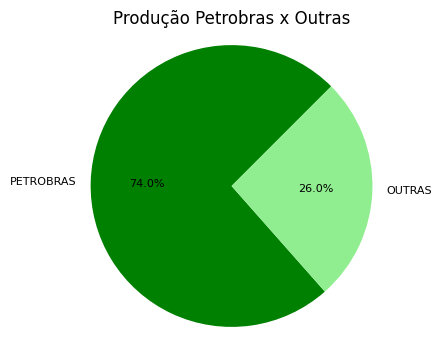

In [0]:
df = _sqldf.toPandas()

# cores personalizadas 
cores_personalizadas = ['green', 'lightgreen', 'lightgreen', 'lightgray']
# plotando gráfico de pizza
plt.figure(figsize=(4,4))
plt.pie(
    df['percentual_operadora'], 
    labels=df['Operadora'], 
    autopct='%1.1f%%', 
    startangle=45,
    colors=cores_personalizadas,
    textprops={'fontsize': 8}
)
plt.title('Produção Petrobras x Outras')
plt.axis('equal')  # Para deixar o gráfico circular
plt.show()

**Análise do Resultado**:

A Petrobras é a principal operadora da Bacia de Campos, responsável por cerca de 12 bilhões de barris de óleo equivalente, o que corresponde a aproximadamente 74% do total produzido na região. Como empresa estatal brasileira, a Petrobras desempenha papel fundamental na exploração, desenvolvimento e produção dos campos petrolíferos da bacia, aplicando tecnologia de ponta e expertise acumulada ao longo de décadas.

A atuação da Petrobras na Bacia de Campos contribui diretamente para a segurança energética do Brasil, garantindo o abastecimento interno de petróleo e derivados, reduzindo a dependência de importações. Além disso, a empresa é um motor de inovação tecnológica, investindo em métodos avançados de recuperação secundária e terciária, que permitem a maximização da extração em campos maduros, prolongando a vida útil das reservas.





### 6.2.3. Qual é o ranking de produção por empresa, excluindo a Petrobras?
Os volumes serão expressos em bilhões de barris de óleo equivalente.

In [0]:
%sql
-- obtém o total produzido por empresa (exceto PETROBRAS) e ordena de forma decrescente por volume produzido   
SELECT 
    emp.Empresa,
    SUM(prod.vol_producao_bbl) AS Producao
FROM mvp_producao.dados_producao.ft_producao prod
INNER JOIN mvp_producao.dados_producao.dm_empresa emp 
        ON prod.id_empresa = emp.id_empresa
WHERE emp.Empresa NOT LIKE '%PETROBRAS%'
GROUP BY emp.Empresa
ORDER BY Producao DESC



Empresa,Producao
Trident Energy do Brasil Ltda.,1.8029655340454068E9
Perenco Petróleo e Gás do Brasil Ltda.,8.827582950835842E8
Petro Rio Jaguar Petróleo SA.,6.458454167369264E8
Shell Brasil Petróleo Ltda.,4.127040082672184E8
Prio Tigris S.A,3.040716957534453E8
Prio Bravo Ltda.,1.0057826587129101E8
3R Petroleum Offshore S.A.,6.201719266618953E7
Prio Forte S.A.,6913365.157284236


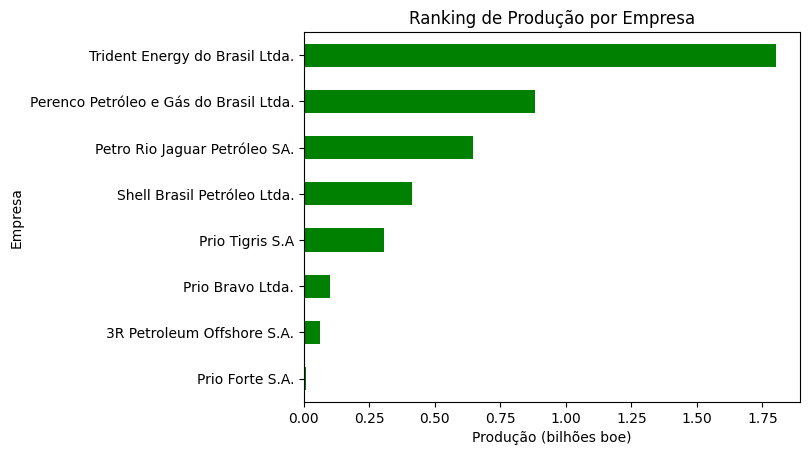

In [0]:
df = _sqldf.toPandas()
# a produção será plotada em bilhões de boe
df["Producao"] = df["Producao"]/1000000000

# criação do gráfico
ax = df.plot.barh(x='Empresa', y='Producao', color='green', legend=False)
# inversão da ordem do eixo Y para que a empresa com maior produção fique no topo
ax.invert_yaxis()

plt.title('Ranking de Produção por Empresa')
plt.xlabel('Produção (bilhões boe)')
plt.ylabel('Empresa')
plt.show()

**Análise do Resultado**:

Embora a Petrobras seja a principal operadora da Bacia de Campos, outras empresas também atuam na região, contribuindo para a diversificação e dinamismo do setor. Essas operadoras, incluindo empresas nacionais e internacionais, participam de blocos exploratórios e de produção em consórcios ou como operadoras independentes em áreas específicas.

Destaque para a Trident, que responde por cerca de 1,8 bilhão de barris de óleo equivalente, seguida pela Perenco, com aproximadamente 882 milhões, e a Petro Rio, com cerca de 646 milhões. Juntas, essas três empresas respondem por cerca de 21% da produção total da bacia, representando 79% da produção não operada pela Petrobras.

Na sequência, destacam-se a Shell, com 412 milhões; Prio Tigres, com 304 milhões; Prio Bravo, com 100 milhões; 3R, com 62 milhões; e, por fim, Prio Forte, com 7 milhões de barris de óleo equivalente.

Embora o volume produzido por essas empresas seja menor em comparação à Petrobras, sua atuação é fundamental para o aumento da produção e para a exploração de áreas que complementam o portfólio da bacia.





### 6.2.4.	Quais são os dez principais campos que mais contribuem para a produção total? 
Os volumes serão expressos em bilhões de barris de óleo equivalente.

In [0]:
%sql
-- obtém o total produzido por campo e ordena de forma decrescente por volume produzido, considerando apenas os dez maiores 
SELECT 
    camp.Campo,
    SUM(prod.vol_producao_bbl)/1000000000 AS Producao
FROM mvp_producao.dados_producao.ft_producao prod
INNER JOIN mvp_producao.dados_producao.dm_campo camp 
        ON prod.id_campo = camp.id_campo
GROUP BY camp.Campo
ORDER BY Producao DESC
LIMIT 10

Campo,Producao
MARLIM,2.892357094276939
RONCADOR,1.827335568011533
MARLIM SUL,1.659384518056658
JUBARTE,1.0484038828059141
ALBACORA,1.0437565679522343
BARRACUDA,0.7238243110947369
MARLIM LESTE,0.5644936305290941
NAMORADO,0.48997198773293843
ALBACORA LESTE,0.4744789731158185
MARIMBÁ,0.4534966393245485


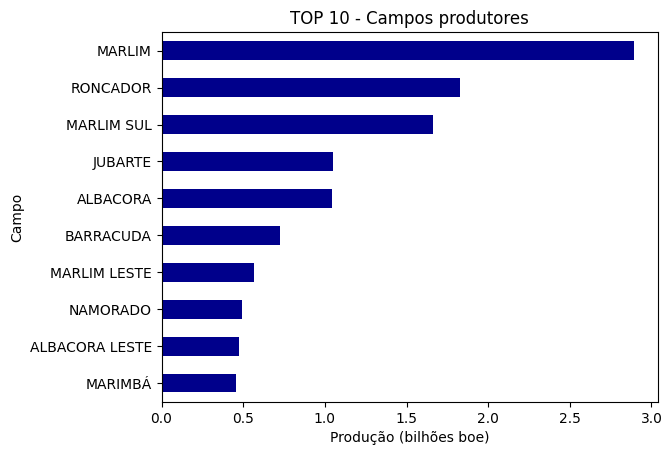

In [0]:
df = _sqldf.toPandas()

# criação do gráfico
ax = df.plot.barh(x='Campo', y='Producao', color='darkblue', legend=False)
# inversão da ordem do eixo Y para que a empresa com maior produção fique no topo
ax.invert_yaxis()

plt.title('TOP 10 - Campos produtores')
plt.xlabel('Produção (bilhões boe)')
plt.ylabel('Campo')
plt.show()

**Análise do Resultado**:

A análise da produção dos dez maiores campos da Bacia de Campos evidencia a concentração significativa da produção em poucos campos estratégicos. O campo de Marlim lidera com folga, contribuindo com aproximadamente 2,9 bilhões de barris de óleo equivalente, o que representa cerca de 18% do total produzido na bacia. Esse destaque reforça a importância do Marlim como base da produção regional e nacional.

Além de Marlim, outros quatro campos ultrapassaram a marca de 1 bilhão de barris: Roncador (1,8 bilhão); Marlim Sul (1,7 bilhão); Jubarte (1 bilhão) e Albacora (1 bilhão). Este resultado demonstra que a produção da bacia está bastante concentrada nesses grandes campos. Juntos, esses cinco campos respondem por uma parcela significativa da produção total (cerca de 52%), indicando que a gestão eficiente e a manutenção da produção nesses ativos são cruciais para a sustentabilidade da bacia.

Os demais campos do Top 10, embora tenham produções menores individualmente, somam volumes relevantes que complementam a produção total da bacia: Barracuda (0,72 bilhão), Marlim Leste (0,56 bilhão), Namorado (0,49 bilhão), Albacora Leste (0,47 bilhão) e Marimbá (0,45 bilhão). Estes campos desempenham papel importante na diversificação da produção e no suporte à continuidade operacional da região.

Essa concentração da produção em campos maduros reforça a necessidade de investimentos contínuos em tecnologias de recuperação avançada e em atividades de manutenção para prolongar a vida útil desses ativos e garantir a estabilidade da produção no longo prazo.


### 6.2.5. Como a produção da bacia evoluiu ao longo do tempo?
Os volumes serão expressos em milhões de barris de óleo equivalente

In [0]:
%sql
-- obtém o total por ano
SELECT 
    dat.Ano,
    SUM(prod.vol_producao_bbl)/1000000 AS Producao
FROM mvp_producao.dados_producao.ft_producao prod
INNER JOIN mvp_producao.dados_producao.dm_data dat 
        ON prod.id_data = dat.id_data
GROUP BY dat.Ano
ORDER BY Ano


Ano,Producao
1977,1.0835493055463998
1978,3.3869382076688392
1979,6.439491508734239
1980,11.570931884295959
1981,21.70193927089849
1982,37.27442091606816
1983,58.778396593587686
1984,100.6112892410637
1985,132.95996353726218
1986,140.62775094845796


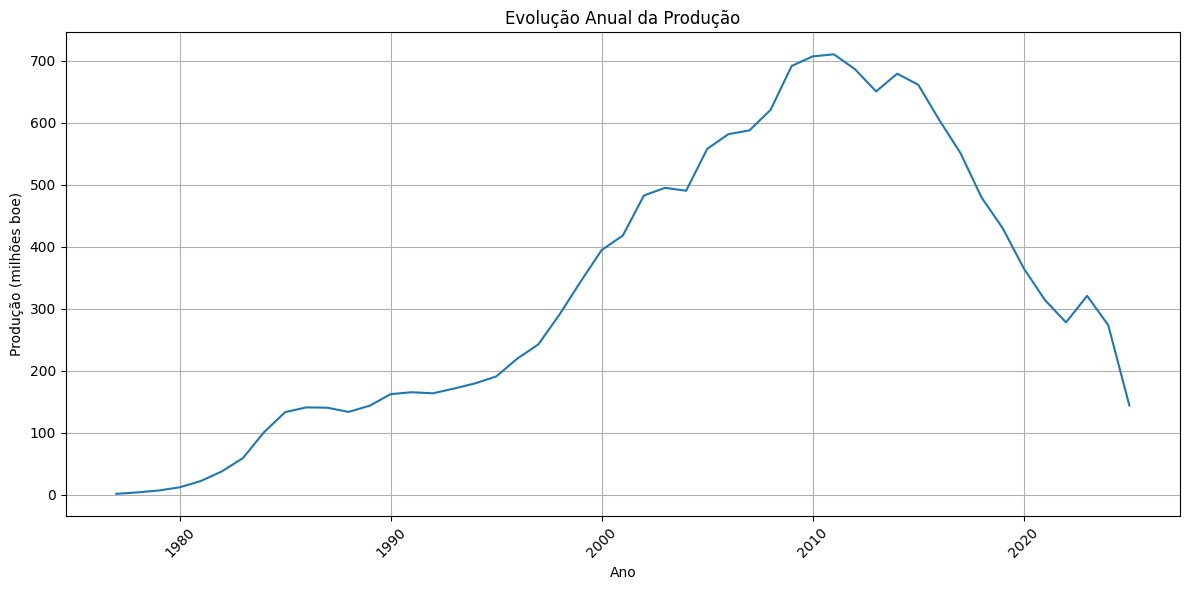

In [0]:
df = _sqldf.toPandas()

# plotando gráfico de linha
plt.figure(figsize=(12,6))
plt.plot(df['Ano'], df['Producao'], marker='', linestyle='-')
plt.title('Evolução Anual da Produção')
plt.xlabel('Ano')
plt.ylabel('Produção (milhões boe)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Análise do Resultado**:

A produção da Bacia de Campos teve início em 1977, quando alcançou o volume de 1 milhão de barris de óleo equivalente. Sete anos depois, em 1984, a produção anual já estava na faixa dos 100 milhões de barris, mantendo um crescimento contínuo até atingir seu ápice em 2011, com 711 milhões de barris produzidos.

Após esse pico, a produção entrou em uma tendência de declínio, com os volumes dos últimos quatro anos situando-se em níveis semelhantes aos registrados no final da década de 1990.

Este cenário demonstra que a maioria dos campos da Bacia de Campos está em estágio avançado de produção, com muitos deles classificados como maduros. Isso significa que a extração está em fases de declínio natural ou estável, exigindo técnicas avançadas para manter a produtividade. Os campos enfrentam desafios técnicos, como a necessidade de recuperação avançada (recuperação secundária e terciária), manejo de pressão, controle de água e gás, e otimização de produção para prolongar a vida útil dos ativos.

A queda pode ser mitigada com investimentos em recuperação avançada (recuperação secundária e terciária), mas isso depende da viabilidade econômica e tecnológica.


### 6.2.6.	Qual o perfil de produção por faixa de profundidade (águas rasa, profunda e ultra profunda)

In [0]:
%sql

-- obtém a produção total acumulada por perfil de profundidade
WITH producao_total AS (
    SELECT 
        SUM(prod.vol_producao_bbl) AS total_geral
    FROM mvp_producao.dados_producao.ft_producao prod
),
producao_prof AS (
    SELECT
        prof.Profundidade,
        SUM(prod.vol_producao_bbl) AS total_prof
    FROM mvp_producao.dados_producao.ft_producao prod
    INNER JOIN mvp_producao.dados_producao.dm_profundidade prof 
            ON prod.id_profundidade = prof.id_profundidade
    GROUP BY prof.Profundidade
)

SELECT 
    ppr.Profundidade,
    ppr.total_prof AS Producao,
    ROUND((total_prof / (SELECT total_geral FROM producao_total)) * 100, 2) AS Percentual_Producao
FROM producao_prof ppr
ORDER BY percentual_producao DESC;
    

Profundidade,Producao,Percentual_Producao
Profunda,1.054074404108648E10,64.93
Rasa,3.622153933575295E9,22.31
Ultra profunda,2.0703684330196393E9,12.75


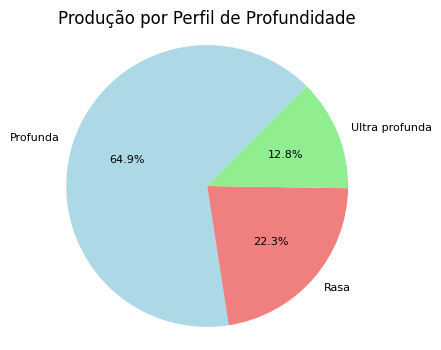

In [0]:
df = _sqldf.toPandas()

# cores personalizadas 
cores_personalizadas = ['lightblue', 'lightcoral', 'lightgreen', 'lightgray']
# plotando gráfico de pizza
plt.figure(figsize=(4,4))
plt.pie(
    df['Percentual_Producao'], 
    labels=df['Profundidade'], 
    autopct='%1.1f%%', 
    startangle=45,
    colors=cores_personalizadas,
    textprops={'fontsize': 8}
)
plt.title('Produção por Perfil de Profundidade')
plt.axis('equal')  # Para deixar o gráfico circular
plt.show()

**Análise do Resultado**: 

A produção da Bacia de Campos está concentrada majoritariamente em águas profundas, com lâmina d’água entre 300 e 1.500 metros, representando 64,9% do total produzido. Em seguida, a produção em águas rasas (lâmina d’água até 300 metros) corresponde a 22,3%, enquanto a produção em águas ultraprofundas (acima de 1.500 metros) representa 12,8%.

Esse cenário evidencia a complexidade da produção na Bacia de Campos, uma vez que operar em águas profundas envolve diversos desafios técnicos, operacionais e econômicos. Para garantir a exploração e a produção eficientes e seguras, é necessária uma infraestrutura robusta e o emprego de tecnologias sofisticadas.

### 6.2.7.	Qual o perfil de produção por tipo de petróleo (leve, médio, pesado e extrapesado)?

In [0]:
%sql

-- obtém a produção total acumulada por tipo de petróleo
WITH producao_total AS (
    SELECT 
        SUM(prod.vol_producao_bbl) AS total_geral
    FROM mvp_producao.dados_producao.ft_producao prod
),
producao_tpp AS (
    SELECT
        tpp.Tipo_petroleo,
        SUM(prod.vol_producao_bbl) AS total_tpp
    FROM mvp_producao.dados_producao.ft_producao prod
    INNER JOIN mvp_producao.dados_producao.dm_tp_petroleo tpp 
            ON prod.id_tp_petroleo = tpp.id_tp_petroleo
    GROUP BY tpp.Tipo_petroleo
)

SELECT 
    ptpp.Tipo_petroleo,
    ptpp.total_tpp AS Producao,
    ROUND((total_tpp / (SELECT total_geral FROM producao_total)) * 100, 2) AS Percentual_Producao
FROM producao_tpp ptpp
ORDER BY percentual_producao DESC;

Tipo_petroleo,Producao,Percentual_Producao
Médio,9.725434934365835E9,59.91
Pesado,6.496431469304316E9,40.02
Leve,1.1400004011234306E7,0.07


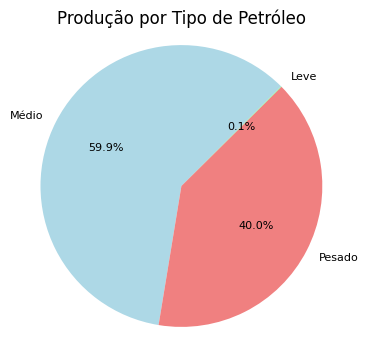

In [0]:
df = _sqldf.toPandas()

# cores personalizadas 
cores_personalizadas = ['lightblue', 'lightcoral', 'lightgreen', 'lightgray']
# Plotar gráfico de pizza
plt.figure(figsize=(4,4))
plt.pie(
    df['Percentual_Producao'], 
    labels=df['Tipo_petroleo'], 
    autopct='%1.1f%%', 
    startangle=45,
    colors=cores_personalizadas,
    textprops={'fontsize': 8}
)
plt.title('Produção por Tipo de Petróleo')
plt.axis('equal')  # Para deixar o gráfico circular
plt.show()

**Análise do Resultado**:

A Bacia de Campos produz principalmente petróleo dos tipos médio e pesado, com ocorrência pequena de petróleo leve em algumas áreas.

O petróleo leve (API acima de 30°) possui menor densidade e viscosidade, facilitando seu escoamento e processamento. Embora seja valorizado no mercado por gerar maiores volumes de derivados de maior valor agregado, como gasolina e diesel, sua participação na bacia é ínfima, representando menos de 1% da produção total.

O petróleo médio (API entre 22° e 30°), com características intermediárias entre o leve e o pesado, exige processos de refino um pouco mais complexos, mas ainda mantém boa qualidade para diversos produtos. Esse tipo de petróleo é predominante na Bacia de Campos, correspondendo a cerca de 60% do total produzido.

Já o petróleo pesado (API entre 10° e 21,9°) é mais denso e viscoso, apresentando maior dificuldade para extração, transporte e refino. O tratamento desse tipo de óleo demanda processos adicionais, como diluição e técnicas avançadas de recuperação. Ele representa aproximadamente 40% da produção total.

A diversidade dos tipos de petróleo produzidos na Bacia de Campos exige que as operadoras adotem diferentes estratégias tecnológicas para otimizar a produção, o transporte e o processamento, garantindo a eficiência e o valor econômico da produção.


### 6.2.8.	Quando foi registrado o recorde mensal de produção?
Os volumes serão expressos em milhões de barris de óleo equivalente.

In [0]:
%sql

-- obtém o recorde de produção mensal em milhões de boe
SELECT 
    dat.Ano,
    dat.Mes,
    ROUND(SUM(prod.vol_producao_bbl)/1000000, 2) AS Producao
FROM mvp_producao.dados_producao.ft_producao prod
INNER JOIN mvp_producao.dados_producao.dm_data dat 
        ON prod.id_data = dat.id_data
GROUP BY dat.Ano, dat.Mes
ORDER BY Producao DESC
LIMIT 5


Ano,Mes,Producao
2012,1,63.71
2010,12,63.58
2011,12,62.56
2011,1,62.13
2014,12,61.77


**Análise do Resultado**:

O recorde de produção mensal da Bacia de Campos foi de 63,71 milhões de barris de óleo equivalente, alcançado em janeiro de 2012, trinta e cinco anos após o início das operações na bacia. Apenas em outra oportunidade a produção mensal atingiu o patamar de 63 milhões de barris, em dezembro de 2010.

### 6.2.9. Como é a distribuição da produção acumulada por Unidade da Federação?

In [0]:
%sql
-- obtém a produção total acumulada por UF
WITH producao_total AS (
    SELECT 
        SUM(prod.vol_producao_bbl) AS total_geral
    FROM mvp_producao.dados_producao.ft_producao prod
),
producao_cpo AS (
    SELECT
        cpo.estado,
        SUM(prod.vol_producao_bbl) AS total_tpp
    FROM mvp_producao.dados_producao.ft_producao prod
    INNER JOIN mvp_producao.dados_producao.dm_campo cpo 
            ON prod.id_campo = cpo.id_campo
    GROUP BY cpo.estado
)

SELECT 
    pcpp.estado,
    pcpp.total_tpp AS Producao,
    ROUND((total_tpp / (SELECT total_geral FROM producao_total)) * 100, 2) AS Percentual_Producao
FROM producao_cpo pcpp
ORDER BY percentual_producao DESC;

estado,Producao,Percentual_Producao
RJ,1.4568696053482035E10,89.75
ES,1.664570354199347E9,10.25


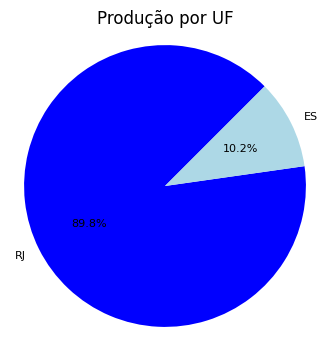

In [0]:
df = _sqldf.toPandas()

# cores personalizadas 
cores_personalizadas = ['blue', 'lightblue']
# Plotar gráfico de pizza
plt.figure(figsize=(4,4))
plt.pie(
    df['Percentual_Producao'], 
    labels=df['estado'], 
    autopct='%1.1f%%', 
    startangle=45,
    colors=cores_personalizadas,
    textprops={'fontsize': 8}
)
plt.title('Produção por UF')
plt.axis('equal')  # Para deixar o gráfico circular
plt.show()

**Análise do Resultado**:

A maior parte da produção da Bacia de Campos está concentrada no Estado do Rio de Janeiro, cerca de 90%, refletindo sua relevância estratégica para o setor energético nacional. Essa concentração justifica, entre outros fatores, a escolha do Rio de Janeiro como sede da Petrobras e de outras empresas do setor, facilitando a logística, a gestão operacional e o desenvolvimento tecnológico diretamente ligados à exploração e produção de petróleo. 

O Espírito Santo, apesar de representar uma parcela menor na produção, com cerca de 10%, também desempenha um papel importante e complementar no cenário energético nacional, contribuindo para a diversificação e sustentação da produção da bacia.

### 6.2.10.	Em que momentos foram alcançados os marcos de produção acumulada de 1 bilhão, 5 bilhões, 10 bilhões e 15 bilhões?

In [0]:
%sql
-- calcula a produção acumulada por ano
WITH producao_mensal AS (
        SELECT
            dat.ano,
            SUM(prod.vol_producao_bbl) AS producao
        FROM mvp_producao.dados_producao.ft_producao prod
        INNER JOIN mvp_producao.dados_producao.dm_data dat 
                ON prod.id_data = dat.id_data
        GROUP BY dat.ano
),
producao_acumulada AS (
        SELECT
            ano,
            producao,
            SUM(producao) OVER (ORDER BY ano ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS producao_cumulativa
        FROM producao_mensal
),
marcos AS (
            SELECT 1000000000 AS meta UNION ALL
            SELECT 5000000000 UNION ALL
            SELECT 10000000000 UNION ALL
            SELECT 15000000000
)
-- obtém os anos em que as metas foram atingidas
SELECT
    mar.meta,
    MIN(prod.ano) AS data_atingida,
    MIN(prod.producao_cumulativa) AS producao_cumulativa_atingida
FROM 
    marcos mar
INNER JOIN producao_acumulada prod 
        ON prod.producao_cumulativa >= mar.meta
GROUP BY mar.meta
ORDER BY mar.meta;


meta,data_atingida,producao_cumulativa_atingida
1000000000,1990,1.0930794902208936E9
5000000000,2004,5.339051006118509E9
10000000000,2012,1.0483368751165176E10
15000000000,2021,1.5217706658379477E10


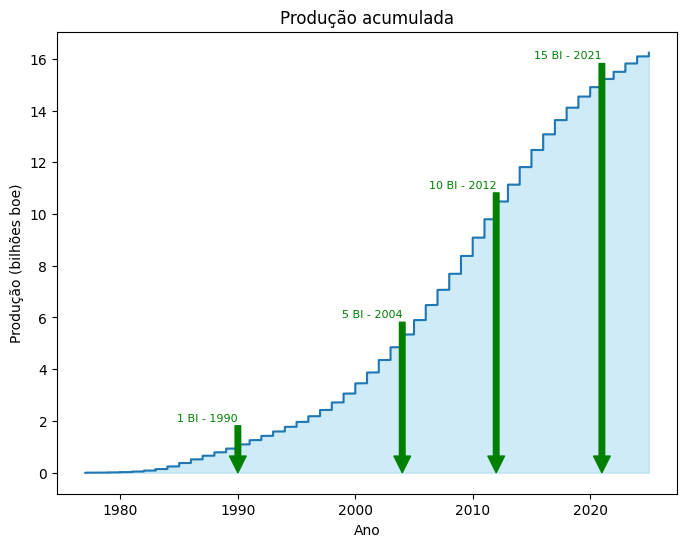

In [0]:
# execução da consulta SQL para obter a produção acumulada e conversão para Pandas
df_producao = spark.sql(
        "SELECT " + 
            "dat.ano, " +
            "prod.vol_producao_bbl, " + 
            "SUM(prod.vol_producao_bbl) OVER (ORDER BY ano ROWS BETWEEN "+ "UNBOUNDED PRECEDING AND CURRENT ROW) AS producao_cumulativa " + 
        "FROM mvp_producao.dados_producao.ft_producao prod " +
        "INNER JOIN mvp_producao.dados_producao.dm_data dat " +
        "        on prod.id_data = dat.id_data "
).toPandas()

# criação da figura e dos eixos
fig, ax = plt.subplots(figsize=(8, 6))

# a produção será plotada em bilhões de boe
df_producao['producao_cumulativa'] = df_producao['producao_cumulativa']/1000000000
plt.plot(df_producao['ano'], df_producao['producao_cumulativa'],         label='producao_cumulativa')
plt.fill_between(df_producao['ano'], df_producao['producao_cumulativa'], color='skyblue', alpha=0.4) 

# percorrendo o dataframe gerado com as metas para anotar no gráfico
df_marcos =_sqldf.toPandas()
df_marcos["meta"] = df_marcos["meta"]/1000000000

for indice, linha in df_marcos.iterrows():
    # montagem das anotações indicando os marcos
    ax.annotate(
        f"{linha['meta']:.0f} BI - {linha['data_atingida']:.0f}",
        xy=(linha['data_atingida'], 0),
        xytext=(linha['data_atingida'], linha['meta'] + 1),
        ha='right',
        arrowprops=dict(facecolor='green', edgecolor='green', shrink=0.0), 
        fontsize=8, 
        color='green'
    )       

# plotagem do gráfico
plt.title('Produção acumulada')
plt.xlabel('Ano')
plt.ylabel('Produção (bilhões boe)')
plt.show()


**Análise do Resultado**:

A produção da Bacia de Campos teve início em 1977. Foram necessários treze anos para que a bacia atingisse a marca de 1 bilhão de barris de óleo equivalente acumulados.

Atingiu-se a marca de 5 bilhões de barris em 2004, quatorze anos após o primeiro marco.

Em um ritmo acelerado, outros 5 bilhões foram somados à produção total em menos tempo, com a marca de 10 bilhões alcançada em 2012. Nove anos depois, em 2021, a produção acumulada atingiu 15 bilhões de barris.

A marca de 20 bilhões de barris de óleo equivalente em curto espaço de tempo passa a ser um desafio, considerando que a maioria dos campos da Bacia de Campos encontra-se em estágio avançado de produção, conforme destacado na seção 6.2.5. Muitos desses campos são classificados como maduros, com a extração em fases de declínio natural ou estabilização, o que exige a aplicação de técnicas avançadas para manutenção da produtividade.



 


### 6.3. Análise Geral

O objetivo deste projeto foi alcançado ao consolidar e tornar acessíveis informações de produção da Bacia de Campos, permitindo a identificação das principais tendências e fatores relevantes para uma melhor capacidade analítica.

Destaques das análises realizadas:
- A Petrobras é a principal operadora dos campos da bacia, com participação superior a 74%. Outras três empresas, Trident, Perenco e Petro Rio, contribuem com cerca de 21% da produção.
- Os campos localizados no Estado do Rio de Janeiro representam quase 90% do total produzido na bacia.
- Cinco campos respondem por aproximadamente 52% da produção total: Marlim, Roncador, Marlim Sul, Jubarte e Albacora.
- A produção é predominantemente de petróleo médio e pesado, com pequenas ocorrências de petróleo leve em algumas áreas, e está majoritariamente concentrada em águas profundas.

Com base nestes resultados, destacam-se os principais desafios na produção da Bacia de Campos:
- Declínio natural da produção: após o pico em 2011, a bacia enfrenta um declínio gradual da produção, exigindo estratégias eficientes de recuperação e manutenção da produção para prolongar a vida útil dos campos.
- Complexidade técnica das operações offshore em águas profundas: a produção está concentrada majoritariamente em águas profundas, o que implica elevados custos operacionais, necessidade de tecnologia avançada e gestão rigorosa de riscos.
- Diversificação e aumento da participação de outras operadoras: a presença majoritária da Petrobras traz desafios relacionados à competitividade, regulação e integração das operações com outras empresas como Trident, Perenco e Petro Rio.
- Desafio associado à predominância do petróleo médio: o petróleo médio exige processos específicos de refino e transporte, podendo demandar investimentos adicionais em infraestrutura e adaptação das cadeias produtivas para otimizar o aproveitamento e comercialização do produto.
- Concentração da produção em poucos campos: a dependência significativa de cinco campos representa um risco operacional e econômico, tornando a produção vulnerável a eventuais problemas técnicos, paradas não planejadas ou esgotamento precoce dessas áreas.










## 7. Autoavaliação
---

### 7.1. Atingimento dos ojetivos

O principal objetivo deste MVP foi construir um pipeline de dados na nuvem utilizando **Databricks** para integrar, processar e analisar dados de produção de petróleo da Bacia de Campos. O pipeline contemplou as seguintes etapas:

- Busca e coleta dos dados necessários no Sistema de Consulta de Dados Públicos (CDP) da ANP.
- Carga do arquivo CSV gerado pela consulta, armazenado inicialmente no repositório **GitHub**, com posterior ingestão no ambiente **Delta Lake**.
- Modelagem dos dados em esquema estrela, composto por uma tabela fato e cinco tabelas dimensão, com a documentação do modelo por meio de Diagrama de Entidade e Relacionamento e catálogo de dados para cada tabela.
- Leitura do arquivo no ambiente **Databricks** e transformação dos dados em tabelas **Delta**, para manuseio eficiente via **Delta Lake** e processamento distribuído com **Apache Spark**.
- Análise dos dados para responder às questões definidas no início do projeto, utilizando consultas SQL e visualizações gráficas elaboradas com a biblioteca Matplotlib, oferecendo uma visão consolidada e acessível dos dados de produção da Bacia de Campos, problema central deste MVP.

Os objetivos traçados foram plenamente alcançados, com todas as questões levantadas integralmente respondidas. Isso permitiu uma análise aprofundada do comportamento da produção na Bacia de Campos, identificando os principais marcos operacionais e fatores que influenciam a produção. Como resultado, espera-se um aumento da capacidade analítica e o suporte à tomada de decisão estratégica para otimização das operações.



### 7.2. Dificuldades encontradas 

A principal dificuldade inicial do projeto foi a construção do pipeline no **Databricks**, devido à ausência de conhecimento técnico prévio sobre essa plataforma e abordagem. A vasta documentação disponível na internet, especialmente no site oficial do **Databricks**, foi fundamental para superar esse desafio. Após compreender o funcionamento do ambiente, o desenvolvimento do projeto progrediu de forma mais fluida, e as dificuldades restringiram-se à etapa inicial.

Além disso, as discussões e questionamentos levantados durante os encontros ao vivo da disciplina foram essenciais para superar os obstáculos iniciais do projeto, proporcionando esclarecimentos importantes.

Quanto ao tratamento dos dados, foi uma grata surpresa constatar a ausência de problemas relacionados à qualidade dos dados, especialmente considerando que informações provenientes de sistemas públicos de consulta frequentemente não recebem a devida atenção a esse aspecto.



### 7.3. Trabalhos futuros

O resultado final deste MVP proporcionou um aumento significativo da capacidade analítica sobre a produção da Bacia de Campos, por meio da geração de _insights_ baseados nos volumes de produção obtidos no site da ANP. Dessa forma, a primeira iniciativa futura será a atualização periódica desses dados de produção, possibilitando análises sempre atualizadas e mais robustas.

A modelagem de dados foi concebida prevendo a expansão do projeto, incluindo dados geográficos dos campos, como bacia sedimentar, localização (terra ou mar) e estado. A incorporação dos volumes de produção de outras bacias sedimentares também está prevista como iniciativa futura, ampliando a abrangência analítica e permitindo, por exemplo, a comparação da evolução da produção entre diversas bacias.

Além do aumento da base de dados, outros pontos de aprimoramento foram identificados:
- Automação do pipeline por meio da ingestão contínua dos dados, criando um processo automatizado de atualização.
- Desenvolvimento de um dashboard interativo para visualização dinâmica e exploração dos dados.
- Implementação de modelos preditivos, utilizando técnicas de Machine Learning para previsão das curvas de produção futura, entre outras aplicações.


